# Wartość zagrożona na przykładzie cen miedzi

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np, seaborn as sb
import scipy.stats as sc
from arch import arch_model
from statsmodels.api import qqplot
from prettytable import PrettyTable

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.family'] = "Arial"
plt.rcParams["font.size"] = 15

1. Dane 

## 1. Dane - ceny miedzi
Naszymy danymi będą dzienne ceny miedzi od 2018 do 2023 roku. Na ich podstawie liczymy procentowe dzienne zmiany cen i to na nich będziemy dalej pracować. Wszystkich danych jest 1577, z czego ostatnie 400 będą danymi testowymi. 

Projekt był wykonywany z perspektywy KGHM, więc jako ryzyko będziemy traktować spadki cen (lewy ogon rozkładu) i mnożyć przez -1.

In [3]:
copper_prices = pd.read_csv("copper_prices.csv")
copper_prices = pd.DataFrame(copper_prices).to_numpy()

In [4]:
prices = copper_prices[:,1]
dates  = copper_prices[:,0]

In [6]:
diff = prices[1:] - prices[:-1] #dzienne zmiany
X_all = diff/prices[:-1] #dzienne zmiany procentowe
X_all = np.array([round(i,7) for i in X_all])*(-100)

In [7]:
N = len(X_all) # liczba danych
no_test = 400 # liczba danych testowych
no_train = N-400 # liczba danych treningowych

In [8]:
no_test = 400
X_test = X_all[-no_test:]
X = X_all[0:-no_test]

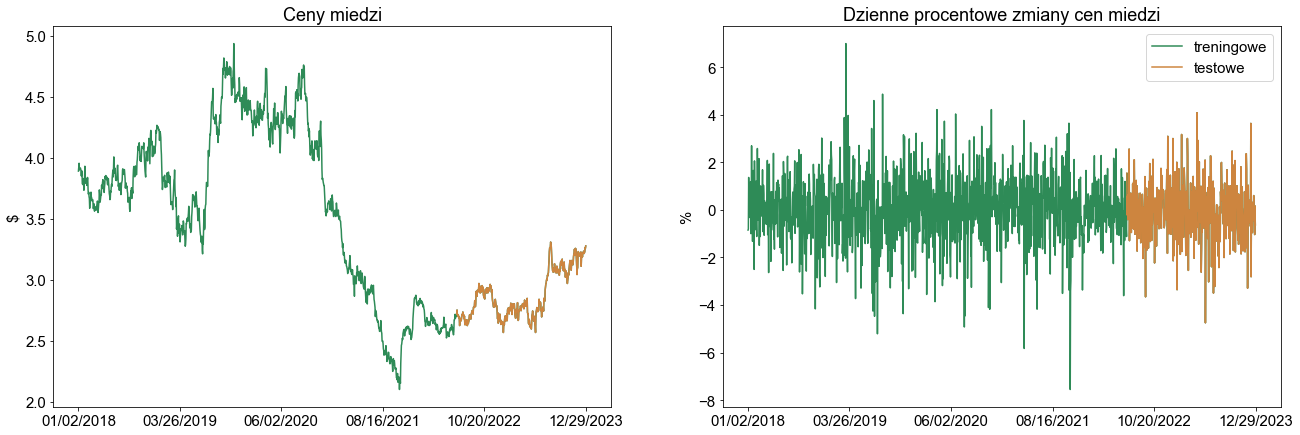

In [9]:
fig,ax = plt.subplots(1,2,figsize=(22,7))

ax[0].plot(range(N+1),prices, label="treningowe",color="seagreen")
ax[0].plot(range(N-400-1,N+1),prices[N-400-1:], label="testowe",color="peru")
ax[0].set_title("Ceny miedzi")
ax[0].set_ylabel(r"$")


no_ticks = 6
ticks_pos = [int(N*i/(no_ticks-1)) for i in range(no_ticks)]
ax[0].set_xticks(ticks_pos,dates[[i for i in ticks_pos]][::-1])

ax[1].plot(range(N),X_all, label="treningowe",color="seagreen")
ax[1].plot(range(N-400,N),X_test, label="testowe",color="peru")
ax[1].set_title("Dzienne procentowe zmiany cen miedzi")
ax[1].set_ylabel(r"%")
ax[1].set_xticks(ticks_pos,dates[[i for i in ticks_pos]][::-1])
ax[1].legend()
fig.suptitle("")

plt.savefig('wykresy/ceny.png', dpi=130)

# 2. Wyznaczanie VaR

## 2.1 Metoda parametryczna

In [10]:
nu, loc, scale = sc.t.fit(X)
nu,loc,scale

(6.545850189712887, 0.040930298945468124, 1.199848694354667)

In [11]:
table = PrettyTable()
table.field_names = ["parametr" ,"wartość"]
parameters = [['nu','loc','scale'], [round(i,5) for i in [nu,loc,scale]]]
for i in range(len(parameters[0])):
    table.add_row([parameters[0][i], parameters[1][i]])
table

parametr,wartość
nu,6.54585
loc,0.04093
scale,1.19985


Testowanie rozkładu

Text(0, 0.5, '')

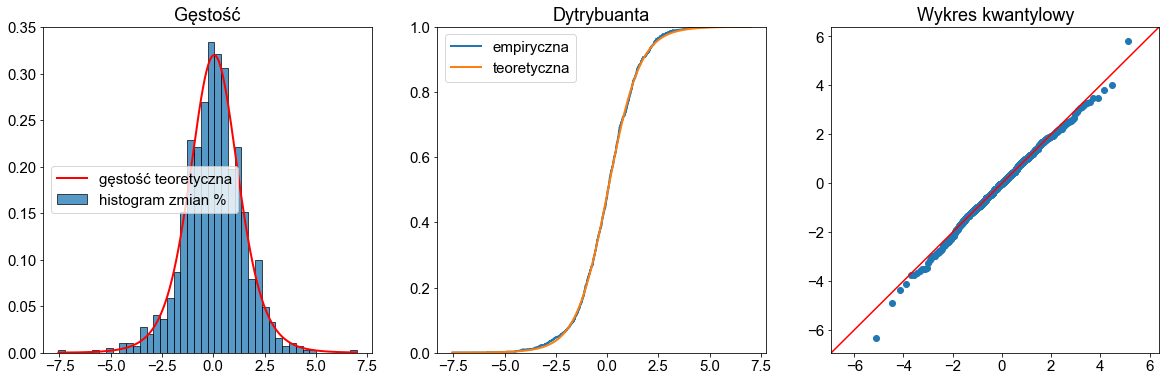

In [12]:
xs = np.linspace(min(X), max(X), 1000)

fig,ax = plt.subplots(1,3,figsize=(20,6))

i=0
sb.histplot(X, stat="density",ax=ax[0],label="histogram zmian %")
ax[i].plot(xs, sc.t.pdf(xs, nu, loc, scale), "r",label="gęstość teoretyczna",linewidth=2)
ax[i].legend()
ax[i].set_title("Gęstość")
ax[i].set_ylabel("")
i += 1
sb.ecdfplot(X,ax=ax[1],label="empiryczna",linewidth=2)
ax[i].plot(xs,sc.t.cdf(xs, nu, loc, scale),label="teoretyczna",linewidth=2)
ax[i].legend()
ax[i].set_title("Dytrybuanta")
ax[i].set_ylabel("")

i+=1
qqplot(X, sc.t,line='45',fit=True, ax=ax[2],linewidth=2)
ax[i].set_title("Wykres kwantylowy")
ax[i].set_xlabel("")
ax[i].set_ylabel("")

#fig.suptitle(f"Dopasowanie do rozkłądu t-studenta({[round(i,3) for i in [nu,loc,scale]]})")

#plt.savefig('wykresy/rozklad.png', dpi=150)

In [13]:
VaR95_1 = sc.t.ppf(0.95, nu, loc, scale)
VaR99_1 = sc.t.ppf(0.99, nu, loc, scale)

In [14]:
table = PrettyTable()
table.field_names = ["VaR " ," wartość "]
VaRs = [VaR95_1,VaR99_1]
alfas = [95,99]
for i in range(len(VaRs)):
    table.add_row([f"VaR{alfas[i]}%",round(VaRs[i],5)])
table

VaR,wartość
VaR95%,2.33809
VaR99%,3.70869


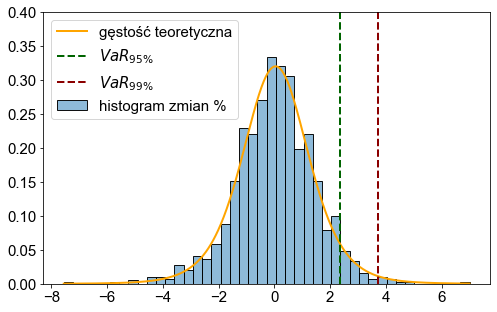

In [15]:
xs = np.linspace(min(X), max(X), 1000)

fig,ax = plt.subplots()
sb.histplot(X, stat="density",ax=ax,label="histogram zmian %",alpha=0.5)
plt.plot(xs, sc.t.pdf(xs, nu, loc, scale), color="orange",label="gęstość teoretyczna",alpha=1,linewidth=2)

#plt.title("Gęstość")
plt.ylabel("")
plt.plot([VaR95_1,VaR95_1],[0,0.4],'--',color='darkgreen',label="$VaR_{95\%}$",linewidth=2)
plt.plot([VaR99_1,VaR99_1],[0,0.4],'--',color='darkred',label="$VaR_{99\%}$",linewidth=2)
plt.legend()
plt.ylim((0,0.4))

plt.savefig('wykresy/hist_param.png',dpi=150)

## 2.2 Metoda historyczna zwykła

In [16]:
VaR95_2 = np.quantile(X, 0.95)
VaR99_2 = np.quantile(X, 0.99)

In [17]:
table = PrettyTable()
table.field_names = ["VaR " ," wartość "]
VaRs = [VaR95_2,VaR99_2]
alfas = [95,99]
for i in range(len(VaRs)):
    table.add_row([f"VaR{alfas[i]}%",round(VaRs[i],5)])
table

VaR,wartość
VaR95%,2.28244
VaR99%,3.44671


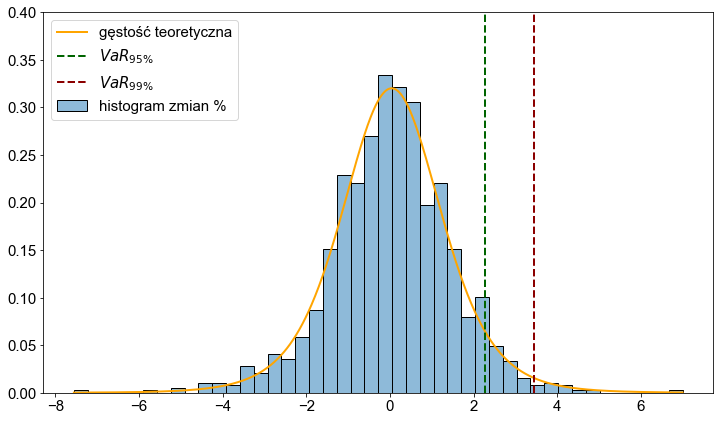

In [18]:
xs = np.linspace(min(X), max(X), 1000)

fig,ax = plt.subplots(figsize=(12,7))
sb.histplot(X, stat="density",ax=ax,label="histogram zmian %",alpha=0.5)
plt.plot(xs, sc.t.pdf(xs, nu, loc, scale), color="orange",label="gęstość teoretyczna",alpha=1,linewidth=2)

#plt.title("Gęstość")
plt.ylabel("")
plt.plot([VaR95_2,VaR95_2],[0,0.4],'--',color='darkgreen',label="$VaR_{95\%}$",linewidth=2)
plt.plot([VaR99_2,VaR99_2],[0,0.4],'--',color='darkred',label="$VaR_{99\%}$",linewidth=2)
plt.legend()
plt.ylim((0,0.4))

plt.savefig('wykresy/hist_hist.png',dpi=150)

## 2.3 Metoda historyczna ważona

In [19]:
lam = 0.95
ls = np.array([lam**i for i in range(len(X))])
w0 = 1/sum(ls)
w = ls*w0

M = zip(reversed(X),w)
M_sort = np.array(sorted(M, key=lambda x: x[0]))

In [20]:
w0

0.05000000000000004

In [21]:
M_dist =  np.cumsum(M_sort[:,1])
M_dist

array([6.3183100e-06, 6.3224317e-06, 6.3224317e-06, ..., 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00])

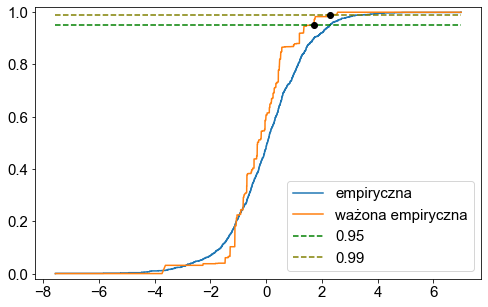

In [22]:
sb.ecdfplot(M_sort[:,0],label="empiryczna")
plt.plot(M_sort[:,0], M_dist,label="ważona empiryczna")
plt.plot([xs[0],xs[-1]],[0.95,0.95],'--',color="green",label="0.95")
plt.plot([xs[0],xs[-1]],[0.99,0.99],'--',color="olive",label="0.99")
plt.plot([1.72],[0.95],'o',color="black")
plt.plot([2.28],[0.99],'o',color="black")
plt.ylim((-0.02,1.02))
plt.ylabel("")
plt.legend()
plt.savefig('wykresy/wazona.png',dpi=130)

In [23]:
alphas = [0.95, 0.99]
Vs = [0,0]
i=0
for alpha in alphas:
    k = np.where([M_dist[k] <= alpha and M_dist[k+1] >= alpha for k in range(len(M_dist)-1)])[0][0]
    Vs[i] = M_sort[:,0][k]
    i += 1
VaR95_3,VaR99_3 = Vs

In [24]:
table = PrettyTable()
table.field_names = ["VaR " ," wartość "]
VaRs = [VaR95_3,VaR99_3]
alfas = [95,99]
for i in range(len(VaRs)):
    table.add_row([f"VaR{alfas[i]}%",round(VaRs[i],5)])
table

VaR,wartość
VaR95%,1.72068
VaR99%,2.28112


## 2.4 Metoda historyczna - GARCH

Rzędy parametrów p i q modelu GARCH wyznaczyliśmy sprawdzając wartości kryteria informacyjnego Akaikego i kreterium informaycjnego Bayesa. Sprawdzaliśmy parametry dla p od 0 do 5 a dla q od 1 do 5. Oba badane kryteria zminimalizowały się dla modelu GARCH(1, 1).

In [25]:
macierz_aic = np.zeros((5,6))
macierz_bic = np.zeros((5,6))
for p in range(1,6):
    for q in range(6):
        am = arch_model(X, p=p, o=0, q=q, dist='t')
        model = am.fit(disp = "off")
        macierz_aic[p-1,q] = model.aic
        macierz_bic[p-1,q] = model.bic
        #print(f'p: {p}, q: {q}, AIC: {model.aic}, BIC: {model.bic}')

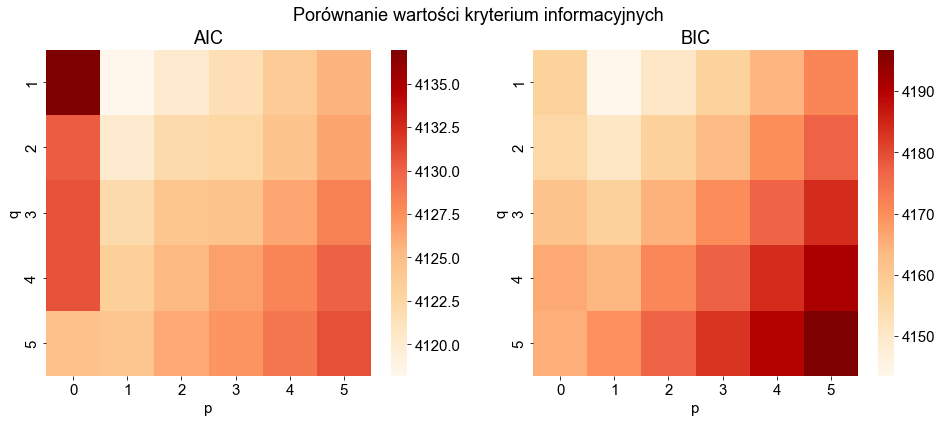

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
i=0
sb.heatmap(macierz_aic,xticklabels=np.arange(0,6,1),yticklabels=np.arange(1,6,1),cmap="OrRd",ax=ax[i])
ax[i].set_title("AIC")
ax[i].set_xlabel("p")
ax[i].set_ylabel("q")
i=1
sb.heatmap(macierz_bic,xticklabels=np.arange(0,6,1),yticklabels=np.arange(1,6,1),cmap="OrRd",ax=ax[i])
ax[i].set_title("BIC")
ax[i].set_xlabel("p")
ax[i].set_ylabel("q")
fig.suptitle("Porównanie wartości kryterium informacyjnych")
plt.savefig("wykresy/aicbic.png",dpi=130)

In [27]:
am = arch_model(X, p=1, o=0, q=1, dist='t')
model = am.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5971.376108593918
Iteration:      2,   Func. Count:     16,   Neg. LLF: 77251.76067138427
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2077.8024308516574
Iteration:      4,   Func. Count:     33,   Neg. LLF: 2629.629023781592
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2057.5222788153087
Iteration:      6,   Func. Count:     47,   Neg. LLF: 2054.132261174232
Iteration:      7,   Func. Count:     53,   Neg. LLF: 2054.0962812320568
Iteration:      8,   Func. Count:     59,   Neg. LLF: 2054.09324313929
Iteration:      9,   Func. Count:     65,   Neg. LLF: 2054.0931733760235
Iteration:     10,   Func. Count:     71,   Neg. LLF: 2054.0931620198944
Iteration:     11,   Func. Count:     76,   Neg. LLF: 2054.0931620198944
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2054.0931620198944
            Iterations: 11
            Function evaluations: 76
            Gradient evaluatio

In [28]:
model.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 45.8578
P-value: 0.0031
Distributed: chi2(23)
WaldTestStatistic, id: 0x207019c4b50

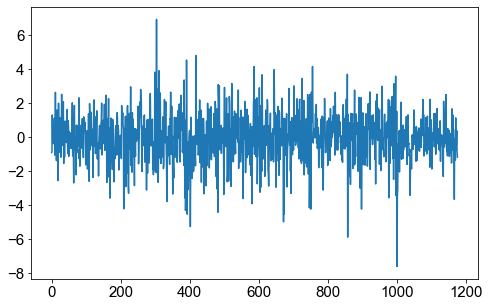

In [29]:
plt.plot(model.resid)

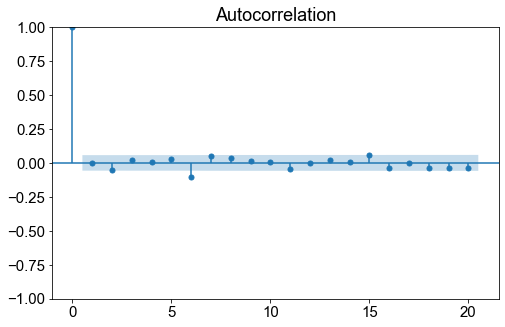

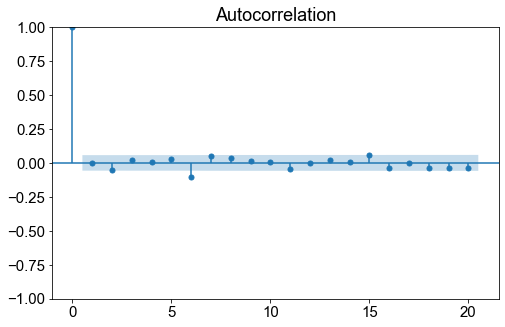

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(model.resid, lags=20)

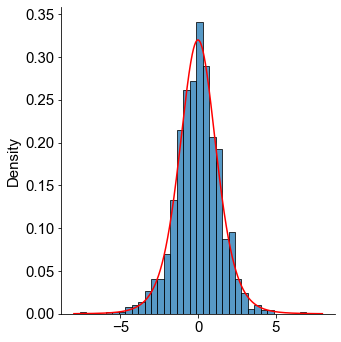

In [31]:
nu, loc, scale = sc.t.fit(model.resid)

xs = np.linspace(-8, 8, 1000)
sb.displot(model.resid, stat="density", bins=35)
plt.plot(xs, sc.t.pdf(xs, nu, loc, scale), "r")

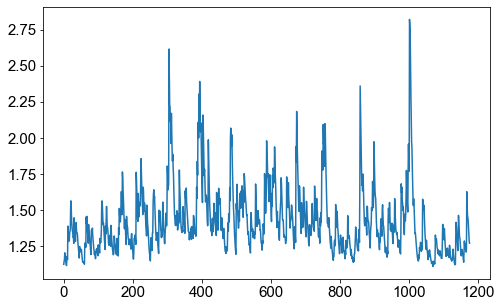

In [32]:
plt.plot(model.conditional_volatility) #sigma_i na wykładzie

In [33]:
filtered_losses = (X - model.params['mu']) / model.conditional_volatility
filtered_q = np.quantile(filtered_losses, [0.95, 0.99])
filtered_q

array([1.59392915, 2.29022527])

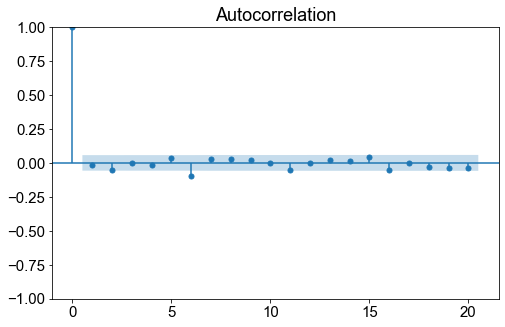

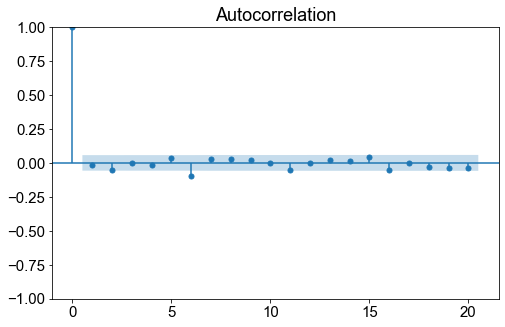

In [34]:
plot_acf(filtered_losses, lags=20) #powinny być iid

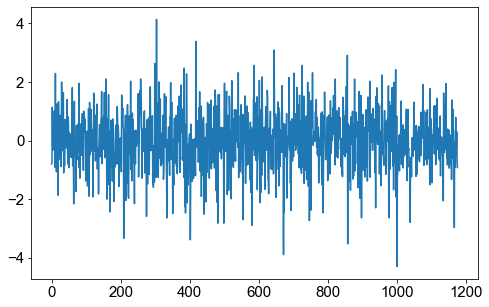

In [35]:
plt.plot(filtered_losses)

In [36]:
forecast = model.forecast()
print('średnia:', forecast.mean.values, ', wariancja:', forecast.variance.values)


średnia: [[0.05098344]] , wariancja: [[1.64102872]]


In [37]:
v = ['95%', '99%']
Vs = [0,0]
for i in range(2):
    #print(f'VaR{v[i]}', (np.sqrt(forecast.variance).values*filtered_q[i]+forecast.mean.values))
    Vs[i] = np.sqrt(forecast.variance).values*filtered_q[i]+forecast.mean.values
VaR95_4, VaR99_4 =[V[0][0] for V in Vs]

In [38]:
table = PrettyTable()
table.field_names = ["VaR " ," wartość "]
VaRs = [VaR95_4,VaR99_4]
alfas = [95,99]
for i in range(len(VaRs)):
    table.add_row([f"VaR{alfas[i]}%",round(VaRs[i],5)])
table

VaR,wartość
VaR95%,2.09285
VaR99%,2.98482


VaR dla dalszych momentów w czasie

In [39]:
forecast = model.forecast(horizon=len(X_test))

L_star = (X + model.params["mu"]) / model.conditional_volatility
q = np.quantile(L_star, [0.95, 0.99])
q

array([1.66220514, 2.37043259])

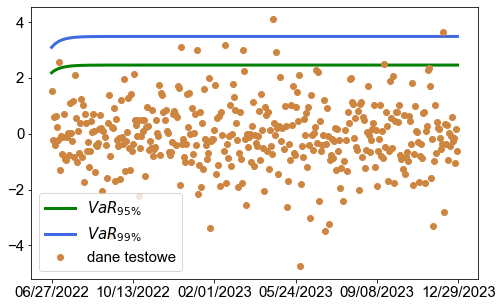

In [40]:
value_at_risk95 = (forecast.mean.values + np.sqrt(forecast.variance).values * q[0])[0]
value_at_risk99 = (forecast.mean.values + np.sqrt(forecast.variance).values * q[1])[0]
#plt.figure(figsize=(15,10))
ticks_pos_test = [int(no_test*i/(no_ticks-1)) for i in range(no_ticks)]
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])

plt.plot(value_at_risk95,'-',label="$VaR_{95\%}$",color="green",linewidth=3)
plt.plot(value_at_risk99,'-',label="$VaR_{99\%}$",color="royalblue",linewidth=3)
plt.plot(X_test, 'o',label="dane testowe",color="peru")
plt.legend()
plt.savefig("wykresy/garch_var.png",dpi=150)

## 2.5 Monte Carlo
Dalsze trajektorie generujemy z modelu GARCH(1,1) z poprzedniego punktu.

In [44]:
horizon = len(X_test)
no_simulation = 10**4
simulationforecast = model.forecast(horizon=horizon, method="simulation", simulations=no_simulation)

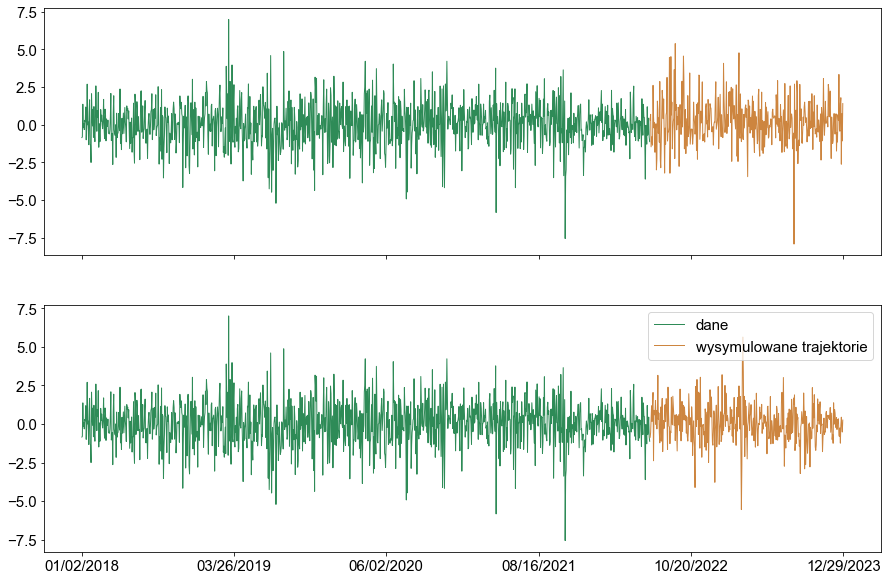

In [45]:
xs = [i + len(X) for i in range(len(simulationforecast.simulations.values[0][0]))]

fig,ax = plt.subplots(2,1,figsize=(15,10))

#plt.figure(figsize=(15,10))
for i in range(2):
    ax[i].plot(X,color="seagreen",linewidth=1,label="dane")
#plt.plot(xs,X_test,color="black")
#plt.plot(xs, simulationforecast.simulations.values[0][1],'--',linewidth=1)
for i in range(2): 
    ax[i].plot(xs, simulationforecast.simulations.values[0][i+8],linewidth=1,color="peru",label="wysymulowane trajektorie")
ax[1].legend()
ax[0].set_xticks(ticks_pos,["" for i in ticks_pos])
ax[1].set_xticks(ticks_pos,dates[[i for i in ticks_pos]][::-1])
plt.savefig("wykresy/trajektorie.png",dpi=150)

In [46]:
simulated_X = [simulationforecast.simulations.values[0][i][-1] for i in range(no_simulation)]

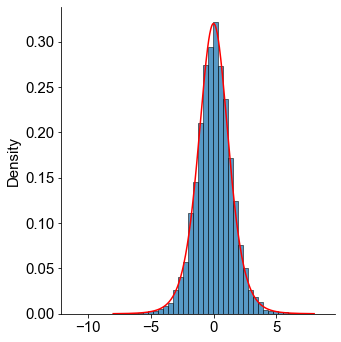

In [47]:
nu, loc, scale = sc.t.fit(model.resid)

xs = np.linspace(-8, 8, 1000)
sb.displot(simulated_X, stat="density", bins=50)
plt.plot(xs, sc.t.pdf(xs, nu, loc, scale), "r")

In [49]:
q = np.quantile(simulated_X, [0.95, 0.99])
print(f"VaR 0.95: {q[0]}")
print(f"VaR 0.99: {q[1]}")

VaR 0.95: 2.324507342840419
VaR 0.99: 3.611072101185626


VaR dla dalszych momentów w czasie

In [968]:
VaRs95 = np.zeros(horizon)
VaRs99 = np.zeros(horizon)
for i in range(horizon):
    simulated_X = [simulationforecast.simulations.values[0][j][i] for j in range(no_simulation)]
    VaRs95[i], VaRs99[i] = np.quantile(simulated_X, [0.95, 0.99])

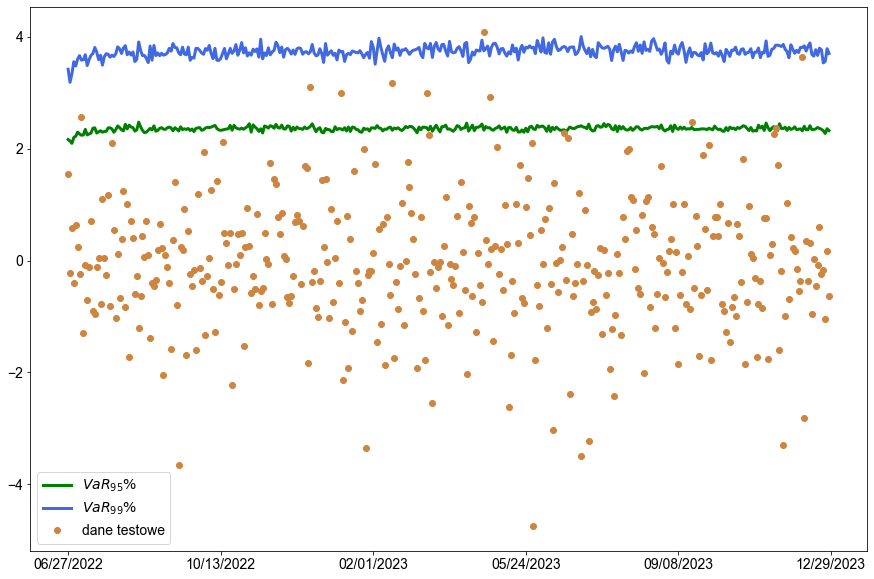

In [969]:

plt.figure(figsize=(15,10))
ticks_pos_test = [int(no_test*i/(no_ticks-1)) for i in range(no_ticks)]
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])

plt.plot(VaRs95,'-',label="$VaR_{95}\%$",color="green",linewidth=3)
plt.plot(VaRs99,'-',label="$VaR_{99}\%$",color="royalblue",linewidth=3)
plt.plot(X_test, 'o',label="dane testowe",color="peru")
plt.legend()
plt.savefig("wykresy/mc_var.png",dpi=150)

# 3. Testowanie wsteczne

In [50]:
def scoring_mean(y, X, alpha=0.95):
    return alpha*np.abs((y <= X)*(X-y)) + (1-alpha)*np.abs((y >= X)*(X-y))

def scorind_mean_est(y, X, alpha=0.95):
    return np.mean(scoring_mean(y, X, alpha=alpha))

## 3.1 Wektory przekroczeń
Sprawdzimy ile danych testowych przekracza wyznaczone poziomy $VaR \alpha \%$ i czy pochodzą one z rozkładu dwumianowego $B(\alpha,\alpha (1-\alpha))$.

### Metoda parametryczna

In [53]:
Ia95 = np.zeros(len(X_test))
Ia99 = np.zeros(len(X_test))
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ia95)):
    nu, loc, scale = sc.t.fit(X_all[i:m+i])
    VaR95 = sc.t.ppf(0.95, nu, loc, scale)
    VaR99 = sc.t.ppf(0.99, nu, loc, scale)
    if X_test[i] > VaR95:
        Ia95[i] = 1
    if X_test[i] > VaR99:
        Ia99[i] = 1
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99

In [54]:
sum(Ia95)/len(Ia95), sum(Ia99)/len(Ia99)

(0.0275, 0.005)

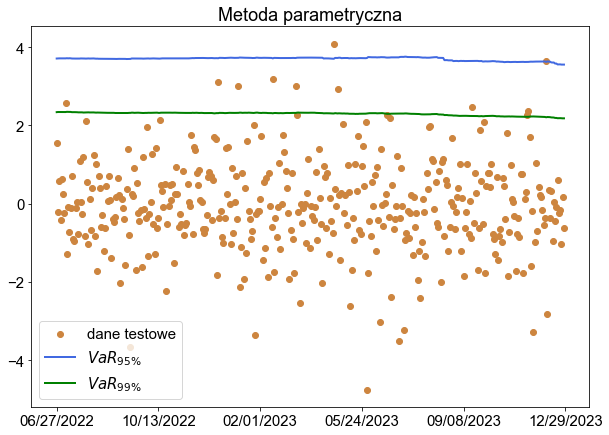

In [58]:
xs_train = np.arange(0, len(X))
xs_test = np.arange(len(X_test))

#plt.plot(xs_train, X)
plt.figure(figsize=(10,7))
plt.scatter(xs_test, X_test,color="peru",label="dane testowe")
plt.plot(xs_test, VaRs99,color="royalblue",label=r"$VaR_{95\%}$",linewidth=2)
plt.plot(xs_test, VaRs95,color="green",label=r"$VaR_{99\%}$",linewidth=2)
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])
plt.legend()
plt.title("Metoda parametryczna")

plt.savefig("wykresy/test_param.png",dpi=150)

In [59]:
mscore1 = scorind_mean_est(VaRs95, X_test)
mscore1_ = scorind_mean_est(VaRs99, X_test, alpha=0.99)

mscore_vals1 = scoring_mean(VaRs95, X_test)
mscore_vals1_ = scoring_mean(VaRs99, X_test, alpha=0.99)

Metoda symulacji historycznej

In [60]:
Ib195 = np.zeros(len(X_test))
Ib199 = np.zeros(len(X_test))
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ib195)):
    VaR95 = np.quantile(X_all[i:m+i], 0.95)
    VaR99 = np.quantile(X_all[i:m+i], 0.99)
    if X_test[i] > VaR95:
        Ib195[i] = 1
    if X_test[i] > VaR99:
        Ib199[i] = 1
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99

In [61]:
sum(Ib195)/len(Ib195), sum(Ib199)/len(Ib199)

(0.0275, 0.005)

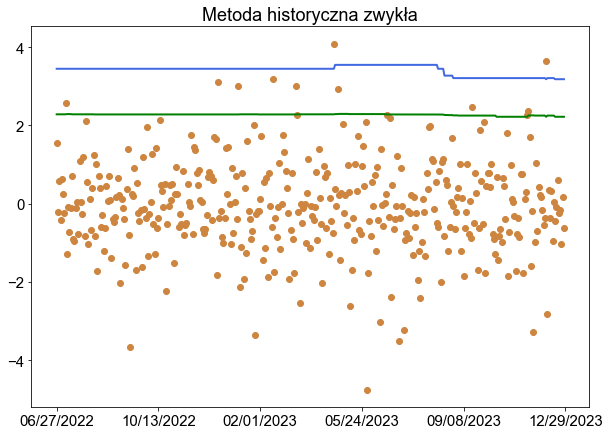

In [62]:
xs_train = np.arange(0, len(X))
xs_test = np.arange(len(X_test))

#plt.plot(xs_train, X)
plt.figure(figsize=(10,7))
plt.scatter(xs_test, X_test,color="peru",label="dane testowe")
plt.plot(xs_test, VaRs99,color="royalblue",label=r"$VaR{95\%}$",linewidth=2)
plt.plot(xs_test, VaRs95,color="green",label=r"$VaR{99\%}$",linewidth=2)
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])
plt.title("Metoda historyczna zwykła")

plt.savefig("wykresy/test_hist.png",dpi=150)

In [63]:
mscore2 = scorind_mean_est(VaRs95, X_test)
mscore2_ = scorind_mean_est(VaRs99, X_test, alpha=0.99)

mscore_vals2 = scoring_mean(VaRs95, X_test)
mscore_vals2_ = scoring_mean(VaRs99, X_test, alpha=0.99)

Metoda symulacji historycznej ważonej

In [64]:
Ib295 = np.zeros(len(X_test))
Ib299 = np.zeros(len(X_test))
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
lam = 0.95

ls = np.array([lam**i for i in range(m)])
w0 = 1/sum(ls)
w = ls*w0

for i in range(len(Ib195)):
    M = zip(reversed(X_all[i:m+i]),w)
    M_sort = np.array(sorted(M, key=lambda x: x[0]))
    M_dist =  np.cumsum(M_sort[:,1])
    k = np.where([M_dist[k] <= 0.95 and M_dist[k+1] >= 0.95 for k in range(len(M_dist)-1)])[0][0]
    VaR95 = M_sort[:,0][k]
    k = np.where([M_dist[k] <= 0.99 and M_dist[k+1] >= 0.99 for k in range(len(M_dist)-1)])[0][0]
    VaR99 = M_sort[:,0][k]
    if X_test[i] > VaR95:
        Ib295[i] = 1
    if X_test[i] > VaR99:
        Ib299[i] = 1
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99


In [65]:
sum(Ib295)/len(Ib295), sum(Ib299)/len(Ib299)

(0.06, 0.025)

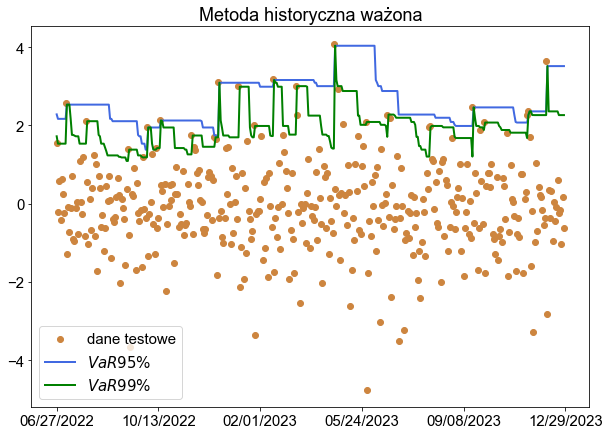

In [66]:

xs_train = np.arange(0, len(X))
xs_test = np.arange(len(X_test))

#plt.plot(xs_train, X)
plt.figure(figsize=(10,7))
plt.scatter(xs_test, X_test,color="peru",label="dane testowe")
plt.plot(xs_test, VaRs99,color="royalblue",label=r"$VaR{95\%}$",linewidth=2)
plt.plot(xs_test, VaRs95,color="green",label=r"$VaR{99\%}$",linewidth=2)
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])
plt.legend()
plt.title("Metoda historyczna ważona")

plt.savefig("wykresy/test_wazona.png",dpi=150)

In [67]:
mscore3 = scorind_mean_est(VaRs95, X_test)
mscore3_ = scorind_mean_est(VaRs99, X_test, alpha=0.99)

mscore_vals3 = scoring_mean(VaRs95, X_test)
mscore_vals3_ = scoring_mean(VaRs99, X_test, alpha=0.99)

Metoda filtrowanej symulacji historycznej (GARCH)

In [68]:
Ib395 = np.zeros(len(X_test))
Ib399 = np.zeros(len(X_test))
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ib395)):
    am = arch_model(X_all[i:m+i], p=1, o=0, q=1, dist='t')
    model = am.fit(disp="off")
    filtered_losses = (X_all[i:m+i] - model.params['mu']) / model.conditional_volatility
    filtered_q = np.quantile(filtered_losses, [0.95, 0.99])
    forecast = model.forecast()
    v = ['95%', '99%']
    VaR95 = (np.sqrt(forecast.variance).values*filtered_q[0]+forecast.mean.values)[0][0]
    VaR99 = (np.sqrt(forecast.variance).values*filtered_q[1]+forecast.mean.values)[0][0]
    if X_test[i] > VaR95:
        Ib395[i] = 1
    if X_test[i] > VaR99:
        Ib399[i] = 1
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99
    

In [69]:
sum(Ib395)/len(Ib395), sum(Ib399)/len(Ib399)

(0.0425, 0.0125)

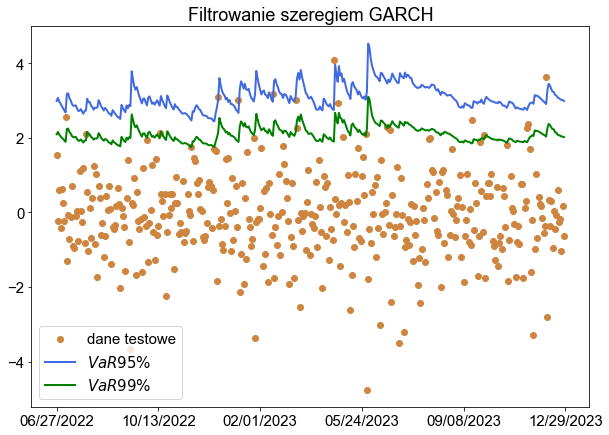

In [70]:

xs_train = np.arange(0, len(X))
xs_test = np.arange(len(X_test))

#plt.plot(xs_train, X)
plt.figure(figsize=(10,7))
plt.scatter(xs_test, X_test,color="peru",label="dane testowe")
plt.plot(xs_test, VaRs99,color="royalblue",label=r"$VaR{95\%}$",linewidth=2)
plt.plot(xs_test, VaRs95,color="green",label=r"$VaR{99\%}$",linewidth=2)
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])
plt.legend()
plt.title("Filtrowanie szeregiem GARCH")

plt.savefig("wykresy/test_garch.png",dpi=150)

In [71]:
mscore4 = scorind_mean_est(VaRs95, X_test)
mscore4_ = scorind_mean_est(VaRs99, X_test, alpha=0.99)

mscore_vals4 = scoring_mean(VaRs95, X_test)
mscore_vals4_ = scoring_mean(VaRs99, X_test, alpha=0.99)

Monte Carlo

In [72]:
Ic95 = np.zeros(len(X_test))
Ic99 = np.zeros(len(X_test))
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

no_simulation = 10**4
m = len(X)
for i in range(len(Ic95)):
    simulationforecast = model.forecast(method="simulation", simulations=no_simulation)
    simulated_X = [simulationforecast.simulations.values[0][i][-1] for i in range(no_simulation)]
    VaR95 = np.quantile(simulated_X, 0.95)
    VaR99 = np.quantile(simulated_X, 0.99)
    if X_test[i] > VaR95:
        Ic95[i] = 1
    if X_test[i] > VaR99:
        Ic99[i] = 1
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99


In [73]:
sum(Ib395)/len(Ib395), sum(Ib399)/len(Ib399)

(0.0425, 0.0125)

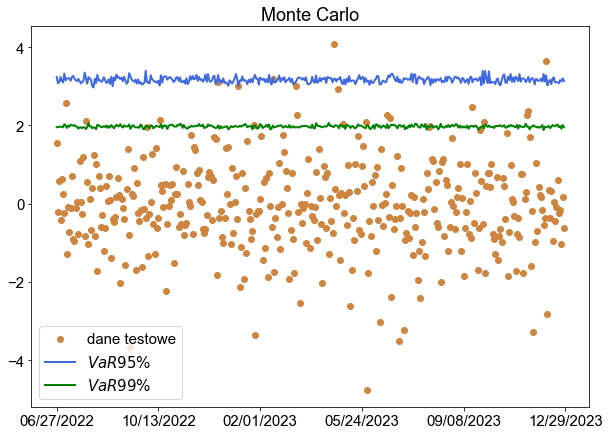

In [74]:

xs_train = np.arange(0, len(X))
xs_test = np.arange(len(X_test))

#plt.plot(xs_train, X)
plt.figure(figsize=(10,7))
plt.scatter(xs_test, X_test,color="peru",label="dane testowe")
plt.plot(xs_test, VaRs99,color="royalblue",label=r"$VaR{95\%}$",linewidth=2)
plt.plot(xs_test, VaRs95,color="green",label=r"$VaR{99\%}$",linewidth=2)
plt.xticks(ticks_pos_test,dates[[i for i in ticks_pos_test]][::-1][-400:])
plt.legend()
plt.title("Monte Carlo")

plt.savefig("wykresy/test_mc.png",dpi=150)

In [75]:
mscore5 = scorind_mean_est(VaRs95, X_test)
mscore5_ = scorind_mean_est(VaRs99, X_test, alpha=0.99)

mscore_vals5 = scoring_mean(VaRs95, X_test)
mscore_vals5_ = scoring_mean(VaRs99, X_test, alpha=0.99)

## 3.2 Test Kupca
Sprawdzimy, czy średnia z wektora przekroczeń równa się $1-\alpha$

In [80]:
alphas = [0.95, 0.99]
Is95 = [Ia95, Ib195, Ib295, Ib395, Ic95]
Is99 = [Ia99, Ib199, Ib299, Ib399, Ic99]
Is = [Is95, Is99]

#zadanie = ["a)     ", "b) I.  ", "b) II. ", "b) III.", "c)     "]
zadanie = ["parametryczna", "historyczna zwykła", "historyczna ważona", "GARCH", "Monte Carlo"]

n = len(Ia95)

for i in range(2):
    print(f"alpha: {alphas[i]}")
    for j in range(len(Is95)):
        I1 = sum(Is[i][j])
        I0 = n - I1
        p = 1 - alphas[i]
        LR = -2*np.log(((1-p)**I0*p**I1) / ((1-I1/n)**I0*(I1/n)**I1))
        p_val = sc.chi2.sf(LR, 1) 
        print(f"Metoda {zadanie[j]} średnia: {I1/n} LR = {round(LR, 6)}, p-value = {round(p_val, 6)}")
    print()

alpha: 0.95
Metoda parametryczna średnia: 0.0275 LR = 5.059081, p-value = 0.024497
Metoda historyczna zwykła średnia: 0.0275 LR = 5.059081, p-value = 0.024497
Metoda historyczna ważona średnia: 0.06 LR = 0.793689, p-value = 0.372987
Metoda GARCH średnia: 0.0425 LR = 0.497979, p-value = 0.48039
Metoda Monte Carlo średnia: 0.0525 LR = 0.051821, p-value = 0.819925

alpha: 0.99
Metoda parametryczna średnia: 0.005 LR = 1.237495, p-value = 0.265954
Metoda historyczna zwykła średnia: 0.005 LR = 1.237495, p-value = 0.265954
Metoda historyczna ważona średnia: 0.025 LR = 6.417186, p-value = 0.011302
Metoda GARCH średnia: 0.0125 LR = 0.233963, p-value = 0.628601
Metoda Monte Carlo średnia: 0.005 LR = 1.237495, p-value = 0.265954



## 3.2 Test Christofersena (test niezależności)

In [79]:
alphas = [0.95, 0.99]
Is95 = [Ia95, Ib195, Ib295, Ib395, Ic95]
Is99 = [Ia99, Ib199, Ib299, Ib399, Ic99]
Is = [Is95, Is99]

#zadanie = ["a)     ", "b) I.  ", "b) II. ", "b) III.", "c)     "]
zadanie = ["parametryczna", "historyczna zwykła", "historyczna ważona", "GARCH", "Monte Carlo"]
n = len(Ia95)

for i in range(2):
    print(f"alpha: {alphas[i]}")
    for j in range(len(Is95)):
        I = Is[i][j]
        I00 = sum([I[i] == 0 and I[i+1] == 0 for i in range(n-1)])
        I01 = sum([I[i] == 0 and I[i+1] == 1 for i in range(n-1)])
        I10 = sum([I[i] == 1 and I[i+1] == 0 for i in range(n-1)])
        I11 = sum([I[i] == 1 and I[i+1] == 1 for i in range(n-1)])

        pi01 = I01/(I00 + I01)
        pi11 = I11/(I10 + I11) #dla alpha=0.99 wychodzi prawie zawsze równe 0
        Lpi = (1-pi01)**I00*pi01**I01*(1-pi11)**I10*pi11*I11

        pi = (I01+I11)/n
        LPI = (1-pi)**(I00+I10)*pi**(I01+I11)

        LR = -2*np.log(LPI/Lpi)
        p_val = sc.chi2.sf(LR, 1) 
        print(f"Metoda {zadanie[j]} LR = {round(LR, 6)}, p-value = {round(p_val, 6)}")


alpha: 0.95
Metoda parametryczna LR = 1.087018, p-value = 0.297133
Metoda historyczna zwykła LR = 1.087018, p-value = 0.297133
Metoda historyczna ważona LR = 6.576044, p-value = 0.010336
Metoda GARCH LR = 0.103403, p-value = 0.747784
Metoda Monte Carlo LR = 6.755912, p-value = 0.009344
alpha: 0.99
Metoda parametryczna LR = -inf, p-value = 1.0
Metoda historyczna zwykła LR = -inf, p-value = 1.0
Metoda historyczna ważona LR = 1.388649, p-value = 0.238633
Metoda GARCH LR = -inf, p-value = 1.0
Metoda Monte Carlo LR = -inf, p-value = 1.0


C:\Users\ola\AppData\Local\Temp\ipykernel_14704\1109957042.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  LR = -2*np.log(LPI/Lpi)


## 3.3 Ranking scoringowy
Wykorzystując empiryczny estymator funkcji scoringowej dla kwantyli możemy posegrewować metody.

In [82]:
scores95 = [mscore1, mscore2, mscore3, mscore4, mscore5]
scores99 = [mscore1_, mscore2_, mscore3_, mscore4_, mscore5_]
scores = [scores95, scores99]
alphas = [0.95, 0.99]

score95_vals = [mscore_vals1, mscore_vals2, mscore_vals3, mscore_vals4, mscore_vals5]
score99_vals = [mscore_vals1_, mscore_vals2_, mscore_vals3_, mscore_vals4_, mscore_vals5_]
score_vals = [score95_vals, score99_vals]
best95 = np.argmin(scores95)
best99 = np.argmin(scores99)
bests = [best95, best99] 
for i in range(2):
    print(f'alphas: {alphas[i]}')
    for j in range(5):
        print(f'Metoda {zadanie[j]} score = {scores[i][j]}, t-test p-value = {sc.ttest_ind(score_vals[i][j], score_vals[i][bests[i]]).pvalue}')


alphas: 0.95
Metoda parametryczna score = 0.13599202105324143, t-test p-value = 0.7209433510363086
Metoda historyczna zwykła score = 0.1353213170000001, t-test p-value = 0.770192096165438
Metoda historyczna ważona score = 0.1439950662500001, t-test p-value = 0.37992495639976154
Metoda GARCH score = 0.13533879616535818, t-test p-value = 0.7882965244109759
Metoda Monte Carlo score = 0.13219861450188933, t-test p-value = 1.0
alphas: 0.99
Metoda parametryczna score = 0.03851170449995208, t-test p-value = 0.21560334637508133
Metoda historyczna zwykła score = 0.037371589050000036, t-test p-value = 0.49777037953248116
Metoda historyczna ważona score = 0.04145798250000002, t-test p-value = 0.3139590248069946
Metoda GARCH score = 0.038053975280586204, t-test p-value = 0.5407651751805609
Metoda Monte Carlo score = 0.03529934784525481, t-test p-value = 1.0


Im niższa wartość funkcji scoringowej, tym lepsze powinno być dopasowanie modelu. Dla obu wartości $\alpha$ wg tego najlepsza jest metoda Monte Carlo, a najgorsza - metoda historyczna ważona.

# 4. Ekspektylowana wartość zagrożona


Miary scoringowe

In [83]:
def scoring_expectile(y, X, alpha=0.95):
    return alpha*np.power((y <= X)*(X-y), 2) + (1-alpha)*np.power((y >= X)*(X-y), 2)

def scorind_expectile_est(y, X, alpha=0.95):
    return np.mean(scoring_expectile(y, X, alpha=alpha))


In [84]:
from scipy.integrate import quad
from scipy.optimize import root_scalar

## 4.1 Metoda parametryczna

In [85]:
VaRs95_ = np.zeros(len(X_test))
VaRs99_ = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ia95)):
    nu, loc, scale = sc.t.fit(X[i:m+i])
    def integral1(t):
        return quad(lambda x: (x-t) * sc.t.pdf(x, nu, loc, scale), t, np.inf)[0]
    def integral2(t):
        return quad(lambda x: (t-x) * sc.t.pdf(x, nu, loc, scale), -np.inf, t)[0]
    def expectile_equation(t, alpha=0.95):
        return alpha*integral1(t) - (1-alpha)*integral2(t)
    
    x0 = sc.t.mean(nu, loc, scale)
    x1 = sc.t.ppf(0.999, nu, loc, scale)

    VaR95 = root_scalar(lambda t: expectile_equation(t, alpha=0.95), x0=x0, x1=x1).root
    VaR99 = root_scalar(lambda t: expectile_equation(t, alpha=0.99), x0=x0, x1=x1).root

    VaRs95_[i] = VaR95
    VaRs99_[i] = VaR99

In [86]:
escore1 = scorind_expectile_est(VaRs95_, X_test)
escore1_ = scorind_expectile_est(VaRs99_, X_test, alpha=0.99)

escore_vals1 = scoring_expectile(VaRs95_, X_test)
escore_vals1_ = scoring_expectile(VaRs99_, X_test, alpha=0.99)

## 4.2 Metoda historyczna zwykła

In [87]:

VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ib195)):
    VaR95 = sc.expectile(X_all[i:m+i], 0.95)
    VaR99 = sc.expectile(X_all[i:m+i], 0.99)

    VaRs95[i] = VaR95
    VaRs99[i] = VaR99

In [88]:
escore2 = scorind_expectile_est(VaRs95, X_test)
escore2_ = scorind_expectile_est(VaRs99, X_test, alpha=0.99)

escore_vals2 = scoring_expectile(VaRs95, X_test)
escore_vals2_ = scoring_expectile(VaRs99, X_test, alpha=0.99)

## 4.3 Metoda historyczna ważona

In [89]:
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
lam = 0.9

ls = np.array([lam**i for i in range(m)])
w0 = 1/sum(ls)
w = ls*w0

for i in range(len(Ib295)):
    M = zip(reversed(X_all[i:m+i]),w)
    M_sort = np.array(sorted(M, key=lambda x: x[0]))
    M_weights = M_sort[:,1]
    M_vals =  M_sort[:,0]
    VaR95 = sc.expectile(M_vals, 0.95, weights=M_weights)
    VaR99 = sc.expectile(M_vals, 0.99, weights=M_weights)
    
    VaRs95[i] = VaR95
    VaRs99[i] = VaR99

In [90]:
escore3 = scorind_expectile_est(VaRs95, X_test)
escore3_ = scorind_expectile_est(VaRs99, X_test, alpha=0.99)

escore_vals3 = scoring_expectile(VaRs95, X_test)
escore_vals3_ = scoring_expectile(VaRs99, X_test, alpha=0.99)

## 4.4 GARCH

In [91]:
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

m = len(X)
for i in range(len(Ib395)):
    am = arch_model(X_all[i:m+i], p=1, o=0, q=1, dist='t')
    model = am.fit(disp="off")
    filtered_losses = (X_all[i:m+i] - model.params['mu']) / model.conditional_volatility
    filtered_q = [sc.expectile(filtered_losses, 0.95), sc.expectile(filtered_losses, 0.99)]
    forecast = model.forecast()
    v = ['95%', '99%']
    VaR95 = (np.sqrt(forecast.variance).values*filtered_q[0]+forecast.mean.values)[0][0]
    VaR99 = (np.sqrt(forecast.variance).values*filtered_q[1]+forecast.mean.values)[0][0]

    VaRs95[i] = VaR95
    VaRs99[i] = VaR99
    

In [92]:
escore4 = scorind_expectile_est(VaRs95, X_test)
escore4_ = scorind_expectile_est(VaRs99, X_test, alpha=0.99)

escore_vals4 = scoring_expectile(VaRs95, X_test)
escore_vals4_ = scoring_expectile(VaRs99, X_test, alpha=0.99)

## 4.5 Monte Carlo

In [93]:
VaRs95 = np.zeros(len(X_test))
VaRs99 = np.zeros(len(X_test))

no_simulation = 10**4
m = len(X)
for i in range(len(Ic95)):
    simulationforecast = model.forecast(method="simulation", simulations=no_simulation)
    simulated_X = [simulationforecast.simulations.values[0][i][-1] for i in range(no_simulation)]
    VaR95 = sc.expectile(simulated_X, 0.95)
    VaR99 = sc.expectile(simulated_X, 0.99)

    VaRs95[i] = VaR95
    VaRs99[i] = VaR99

In [94]:
escore5 = scorind_expectile_est(VaRs95, X_test)
escore5_ = scorind_expectile_est(VaRs99, X_test, alpha=0.99)

escore_vals5 = scoring_expectile(VaRs95, X_test)
escore_vals5_ = scoring_expectile(VaRs99, X_test, alpha=0.99)

## 4.6 Ranking scoringowy

In [95]:
scores95 = [escore1, escore2, escore3, escore4, escore5]
scores99 = [escore1_, escore2_, escore3_, escore4_, escore5_]
scores = [scores95, scores99]
alphas = [0.95, 0.99]

score95_vals = [escore_vals1, escore_vals2, escore_vals3, escore_vals4, escore_vals5]
score99_vals = [escore_vals1_, escore_vals2_, escore_vals3_, escore_vals4_, escore_vals5_]
score_vals = [score95_vals, score99_vals]
best95 = np.argmin(scores95)
best99 = np.argmin(scores99)
bests = [best95, best99] 
for i in range(2):
    print(f'alphas: {alphas[i]}')
    for j in range(5):
        print(f'Metoda {zadanie[j]} score = {scores[i][j]}, t-test p-value = {sc.ttest_ind(score_vals[i][j], score_vals[i][bests[i]]).pvalue}')

alphas: 0.95
Metoda parametryczna score = 0.27714382581300173, t-test p-value = 0.5872416300338872
Metoda historyczna zwykła score = 0.26643998497200666, t-test p-value = 0.8337450198307997
Metoda historyczna ważona score = 0.2968488164025311, t-test p-value = 0.40296065931013714
Metoda GARCH score = 0.2690510700870949, t-test p-value = 0.7905152058407882
Metoda Monte Carlo score = 0.259173080974932, t-test p-value = 1.0
alphas: 0.99
Metoda parametryczna score = 0.1028865818948016, t-test p-value = 0.2179998880175938
Metoda historyczna zwykła score = 0.09257861532392944, t-test p-value = 0.82395570200734
Metoda historyczna ważona score = 0.11796826288326283, t-test p-value = 0.24552001031522547
Metoda GARCH score = 0.09401070159858087, t-test p-value = 0.7851563876372218
Metoda Monte Carlo score = 0.08995522724680431, t-test p-value = 1.0
